# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [ ]:
!pip install pyspark

     |████████████████████████████████| 204.7MB 65kB/s 
     |████████████████████████████████| 204kB 46.3MB/s 
  Created wheel for pyspark: filename=pyspark-3.0.0-py2.py3-none-any.whl size=205044182 sha256=86d50efdbd9df9f8c9b39e84e98c6bb412ab8b33a6d17e3a08fa1a5827226305
  Stored in directory: /root/.cache/pip/wheels/57/27/4d/ddacf7143f8d5b76c45c61ee2e43d9f8492fc5a8e78ebd7d37
Successfully built pyspark


In [ ]:
# import libraries
from pyspark.sql import SparkSession, DataFrame
from pyspark.sql import functions
import pyspark.sql.functions as F
from pyspark.sql.types import *
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler
from distutils.version import LooseVersion
from pyspark.ml.evaluation import BinaryClassificationEvaluator

import numpy
import pandas
import matplotlib.pyplot as plt



In [ ]:
# create a Spark session
spark = SparkSession.builder.getOrCreate()

# Print spark
print(spark)


# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [ ]:
# Don't change this file path
file_path = "/content/mini_sparkify_event_data.json"

# load
chunk = spark.read.json(file_path)

# show
chunk.show()


+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|           page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|      Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|       NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|    Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Bost

In [ ]:
# check for NaN
chunk.select([functions.count(functions.when(functions.isnan(c), c)).alias(c) for c in chunk.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|     0|   0|        0|     0|            0|       0|     0|    0|       0|     0|   0|           0|        0|   0|     0|  0|        0|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+



In [ ]:
# check for Null
chunk.select([functions.count(functions.when(functions.col(c).isNull(), c)).alias(c) for c in chunk.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 58392|   0|     8346|  8346|            0|    8346| 58392|    0|    8346|     0|   0|        8346|        0|58392|     0|  0|     8346|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



In [ ]:
# drop null
chunk = chunk.dropna()

# check for Null
chunk.select([functions.count(functions.when(functions.col(c).isNull(), c)).alias(c) for c in chunk.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|     0|   0|        0|     0|            0|       0|     0|    0|       0|     0|   0|           0|        0|   0|     0|  0|        0|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+



In [ ]:
chunk.count()

228108

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [ ]:
# fixing Churn
def somefunc(value):
  if   value == 'paid': 
      return 'Confirmation'
  else:
      return 'Cancelation'
#convert to a UDF Function by passing in the function and return type of function
udfsomefunc = F.udf(somefunc, StringType())
chunk = chunk.withColumn("Churn", udfsomefunc("level"))
#chunk.show()

In [ ]:
chunk.select(chunk.Churn,chunk.gender).groupBy(chunk.Churn,chunk.gender).count().show()

+------------+------+------+
|       Churn|gender| count|
+------------+------+------+
|Confirmation|     F|104360|
| Cancelation|     F| 22336|
| Cancelation|     M| 19655|
|Confirmation|     M| 81757|
+------------+------+------+



In [ ]:
print(104360+81757)
print(22336+19655)

186117
41991


In [ ]:
chunk.select(chunk.Churn,chunk.location).groupBy(chunk.Churn,chunk.location).count().show()

+------------+--------------------+-----+
|       Churn|            location|count|
+------------+--------------------+-----+
|Confirmation|         Dubuque, IA|  137|
|Confirmation|North Wilkesboro, NC|  326|
|Confirmation|          London, KY|  529|
| Cancelation|Bridgeport-Stamfo...|  277|
|Confirmation|Las Vegas-Henders...| 1250|
| Cancelation|         Dubuque, IA|  366|
| Cancelation|Detroit-Warren-De...|  272|
| Cancelation|Louisville/Jeffer...|  935|
|Confirmation|  Kansas City, MO-KS| 1717|
|Confirmation|    Jacksonville, NC| 1742|
| Cancelation|Baltimore-Columbi...|  318|
|Confirmation|          Laurel, MS|  673|
| Cancelation|North Wilkesboro, NC|  474|
|Confirmation|     Bakersfield, CA|  575|
| Cancelation|Oxnard-Thousand O...|  252|
| Cancelation|Tampa-St. Petersb...|  479|
| Cancelation|       Quincy, IL-MO|  631|
| Cancelation|New Philadelphia-...|  404|
| Cancelation|   Winston-Salem, NC|  125|
| Cancelation|Deltona-Daytona B...|   53|
+------------+--------------------

No handles with labels found to put in legend.


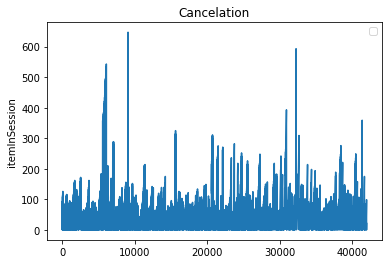

No handles with labels found to put in legend.


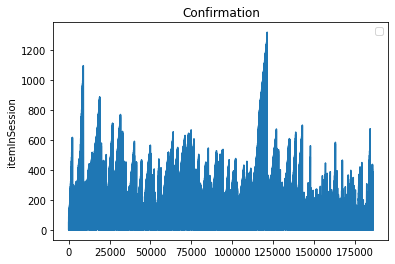

In [ ]:
# converting to  Pandas
churn=chunk.select('Churn').toPandas()
page=chunk.select('itemInSession').toPandas()

idxcan=churn[churn=='Cancelation'].dropna().index
idxcfm=churn[churn=='Confirmation'].dropna().index

# plot page of churn
plt.plot(range(0,41991),page.iloc[idxcan,:].values)
#plt.plot(range(0,186117),page.iloc[idxcfm,:].values)
plt.ylabel('itemInSession')
plt.legend()
plt.title('Cancelation')
plt.show()
#plt.plot(range(0,41991),page.iloc[idxcan,:].values)
plt.plot(range(0,186117),page.iloc[idxcfm,:].values)
plt.ylabel('itemInSession')
plt.legend()
plt.title('Confirmation')
plt.show()

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [ ]:
chunkfin = chunk.select(chunk.Churn,chunk.gender,chunk.location,chunk.itemInSession)

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [ ]:


categoricalColumns = ['gender','location']
stages = [] # stages in our Pipeline
for categoricalCol in categoricalColumns:
    # Category Indexing with StringIndexer
    stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol + "Index")
    # Use OneHotEncoder to convert categorical variables into binary SparseVectors
    #if LooseVersion(pyspark.__version__) < LooseVersion("3.0"):
     #   from pyspark.ml.feature import OneHotEncoderEstimator
     #   encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
#else:
    from pyspark.ml.feature import OneHotEncoder
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    # Add stages.  These are not run here, but will run all at once later on.
    stages += [stringIndexer, encoder]

In [ ]:
# Convert label into label indices using the StringIndexer
label_stringIdx = StringIndexer(inputCol="Churn", outputCol="label")
stages += [label_stringIdx]


In [ ]:
# Transform all features into a vector using VectorAssembler
numericCols = ["itemInSession"]
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [ ]:

### Randomly split data into training and test sets. set seed for reproducibility
(trainingData, testData) = chunkfin.randomSplit([0.7, 0.3], seed=100)
print(trainingData.count())
print(testData.count())

159595
68513


In [ ]:

partialPipeline = Pipeline().setStages(stages)
pipelineModel = partialPipeline.fit(trainingData)
#preppedDataDF = pipelineModel.transform(ch)

In [ ]:
# Fit model to prepped data
#lrModel = LogisticRegression().fit(preppedDataDF)

# ROC for training data
display(pipelineModel, "F1")

PipelineModel_08288e3c5fdb

'F1'

In [ ]:

# Train model with Training Data
lrModel = pipelineModel.transform(trainingData)

In [ ]:
# Make predictions on test data using the transform() method.
# LogisticRegression.transform() will only use the 'features' column.
predictions = pipelineModel.transform(testData)


In [ ]:
# View model's predictions and probabilities of each prediction class
# You can select any columns in the above schema to view as well. For example's sake we will choose age & occupation
selected = predictions.select("Churn", "gender", "location", "itemInSession")
display(selected)

DataFrame[Churn: string, gender: string, location: string, itemInSession: bigint]

In [ ]:

# Evaluate model on minidata
evaluator = BinaryClassificationEvaluator(rawPredictionCol="label")
evaluator.evaluate(predictions)

1.0

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.